In [2]:
import pandas as pd
import numpy as np

# 1. Read the Patient Data
# We force BeneID to be string so it doesn't get messed up
train_ben = pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv', dtype={'BeneID': str})

# 2. Read the Hospital Data (Inpatient)
# We force Provider and BeneID to be strings
train_inp = pd.read_csv('data/Train_Inpatientdata-1542865627584.csv', dtype={'BeneID': str, 'Provider': str})

# 3. Read the Clinic Data (Outpatient)
train_out = pd.read_csv('data/Train_Outpatientdata-1542865627584.csv', dtype={'BeneID': str, 'Provider': str})

# 4. Read the Answer Key
train_lab = pd.read_csv('data/Train-1542865627584.csv', dtype={'Provider': str}) # Assuming this is the labels file

print("All files read successfully!")

FileNotFoundError: [Errno 2] No such file or directory: 'data\\Train_Beneficiarydata-1542865627584.csv'

In [3]:
# --- STEP 1: EXAMINE RELATIONSHIPS & GRANULARITY ---

print("--- 1. CHECKING GRANULARITY (Uniqueness) ---")

# A. Beneficiary Table: Should be 1 row per Patient
is_ben_unique = train_ben['BeneID'].is_unique
print(f"Is BeneID unique in Beneficiary Data? {is_ben_unique}")
print(f"Count of Rows: {len(train_ben)}")
print(f"Count of Unique IDs: {train_ben['BeneID'].nunique()}")

# B. Labels Table: Should be 1 row per Provider
is_prov_unique = train_lab['Provider'].is_unique
print(f"\nIs Provider unique in Labels Data? {is_prov_unique}")
print(f"Count of Rows: {len(train_lab)}")
print(f"Count of Unique IDs: {train_lab['Provider'].nunique()}")

# C. Claims Tables: Rows are Claims, but we check if BeneID repeats (One patient, multiple visits)
print(f"\nInpatient Claims: {len(train_inp)} rows")
print(f"Unique Patients in Inpatient: {train_inp['BeneID'].nunique()}")
print("Observation: Fewer patients than claims --> Proves One-to-Many relationship.")


print("\n--- 2. CHECKING JOIN KEYS (Referential Integrity) ---")

# We must ensure every 'BeneID' in the claims actually exists in the Patient DB
claims_patients = set(train_inp['BeneID']).union(set(train_out['BeneID']))
valid_patients = set(train_ben['BeneID'])

# Find patients in claims who DO NOT exist in the patient database
missing_patients = claims_patients - valid_patients
print(f"Invalid BeneIDs in Claims (patients missing from DB): {len(missing_patients)}")
# EXPECTATION: This should be 0. If > 0, we have data corruption.

# Check Providers the same way
claims_providers = set(train_inp['Provider']).union(set(train_out['Provider']))
valid_providers = set(train_lab['Provider'])
missing_providers = claims_providers - valid_providers
print(f"Invalid Providers in Claims (providers missing from Labels): {len(missing_providers)}")
# EXPECTATION: This should be 0.

--- 1. CHECKING GRANULARITY (Uniqueness) ---
Is BeneID unique in Beneficiary Data? True
Count of Rows: 138556
Count of Unique IDs: 138556

Is Provider unique in Labels Data? True
Count of Rows: 5410
Count of Unique IDs: 5410

Inpatient Claims: 40474 rows
Unique Patients in Inpatient: 31289
Observation: Fewer patients than claims --> Proves One-to-Many relationship.

--- 2. CHECKING JOIN KEYS (Referential Integrity) ---
Invalid BeneIDs in Claims (patients missing from DB): 0
Invalid Providers in Claims (providers missing from Labels): 0


In [4]:
# --- STEP 2: MERGE DATASETS ---

print("Starting the merge process...")

# 1. Add a flag so we know which file the claim came from
train_inp['ClaimType'] = 'Inpatient'
train_out['ClaimType'] = 'Outpatient'

# 2. Merge Patient Details (Beneficiary) onto the Claims
print("Merging Beneficiary data...")
inpatient_full = pd.merge(train_inp, train_ben, on='BeneID', how='left')
outpatient_full = pd.merge(train_out, train_ben, on='BeneID', how='left')

# 3. Combine Inpatient and Outpatient into one giant list
print("Concatenating Inpatient and Outpatient data...")
all_claims = pd.concat([inpatient_full, outpatient_full], axis=0, ignore_index=True)

# 4. Attach the "Fraud Label" (The Target)
print("Attaching Fraud Labels...")
all_claims = pd.merge(all_claims, train_lab, on='Provider', how='left')

# 5. Result
print(f"SUCCESS! Final Dataset Shape: {all_claims.shape}")
# Check if you have approx 558,211 rows

Starting the merge process...
Merging Beneficiary data...
Concatenating Inpatient and Outpatient data...
Attaching Fraud Labels...
SUCCESS! Final Dataset Shape: (558211, 56)


In [5]:
# ---VERIFY MERGE QUALITY ---

print("Original Inpatient Rows:", train_inp.shape[0])
print("Original Outpatient Rows:", train_out.shape[0])
print("Total Expected Rows:", train_inp.shape[0] + train_out.shape[0])

print("\nActual Merged Rows:", all_claims.shape[0])

# Check for "Data Explosion" (Duplicates)
if all_claims.shape[0] > (train_inp.shape[0] + train_out.shape[0]):
    print("WARNING: You have more rows than expected. Check for duplicates!")
else:
    print("SUCCESS: Row count matches exactly.")

# Check for Nulls created by the Left Join
# If this is 0, it means your 'Left Join' acted exactly like an 'Inner Join' (Perfect data)
print("\nNulls in 'ChronicCond_Heartfailure' (from Beneficiary):", all_claims['ChronicCond_Heartfailure'].isnull().sum())
print("Nulls in 'PotentialFraud' (from Labels):", all_claims['PotentialFraud'].isnull().sum())

Original Inpatient Rows: 40474
Original Outpatient Rows: 517737
Total Expected Rows: 558211

Actual Merged Rows: 558211
SUCCESS: Row count matches exactly.

Nulls in 'ChronicCond_Heartfailure' (from Beneficiary): 0
Nulls in 'PotentialFraud' (from Labels): 0


In [ ]:
print(all_claims.describe())
print(all_claims.info())

       InscClaimAmtReimbursed  DeductibleAmtPaid  ClmProcedureCode_1  \
count           558211.000000      557312.000000        23310.000000   
mean               997.012133          78.421085         5896.154612   
std               3821.534891         274.016812         3050.489933   
min                  0.000000           0.000000           11.000000   
25%                 40.000000           0.000000         3848.000000   
50%                 80.000000           0.000000         5363.000000   
75%                300.000000           0.000000         8669.000000   
max             125000.000000        1068.000000         9999.000000   

       ClmProcedureCode_2  ClmProcedureCode_3  ClmProcedureCode_4  \
count         5490.000000          969.000000          118.000000   
mean          4106.358106         4221.123839         4070.262712   
std           2031.640878         2281.849885         2037.626990   
min             42.000000           42.000000           42.000000   
25%   

In [6]:
# --- STEP 3: MISSING VALUES ANALYSIS (PERCENTAGE) ---

# 1. Calculate the count and percentage of missing values
missing_count = all_claims.isnull().sum()
missing_pct = (all_claims.isnull().sum() / len(all_claims)) * 100

# 2. Create a clean DataFrame to view the results
missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_pct
})

# 3. Filter: Only show columns that actually have missing values (Percent > 0)
# And sort them so the worst columns are at the top
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)

# 4. Display the result
print("--- Missing Data Summary ---")
if missing_data.empty:
    print("Perfect! No missing values found.")
else:
    display(missing_data)

--- Missing Data Summary ---


,Missing Count,Missing Percentage (%)
ClmProcedureCode_6,558211,100.000000
ClmProcedureCode_5,558202,99.998388
ClmProcedureCode_4,558093,99.978861
ClmProcedureCode_3,557242,99.826410
DOD,554080,99.259957
ClmDiagnosisCode_10,553201,99.102490
ClmProcedureCode_2,552721,99.016501
ClmProcedureCode_1,534901,95.824160
AdmissionDt,517737,92.749337
DischargeDt,517737,92.749337


In [7]:
# --- CHECKING FOR INCONSISTENCIES ---

print("Checking for logical inconsistencies...")

# 1. Convert relevant columns to Datetime format
# This allows Python to do math on dates (e.g., Date B - Date A)
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']

for col in date_cols:
    if col in all_claims.columns:
        all_claims[col] = pd.to_datetime(all_claims[col], errors='coerce')

# --- CHECK A: The "Ghost" Check (Claims after Death) ---
# Logic: If the Claim Start Date is AFTER the Date of Death (DOD), that's impossible.
if 'DOD' in all_claims.columns:
    ghost_claims = all_claims[all_claims['ClaimStartDt'] > all_claims['DOD']]
    print(f"1. Ghost Claims (Service after Death): {len(ghost_claims)}")

    # See which doctors are doing this!
    if len(ghost_claims) > 0:
        print("   Top providers submitting ghost claims:")
        print(ghost_claims['Provider'].value_counts().head(3))

# --- CHECK B: The "Time Travel" Check (Discharge before Admission) ---
# Logic: You cannot leave the hospital before you arrive.
if 'AdmissionDt' in all_claims.columns and 'DischargeDt' in all_claims.columns:
    time_travel_hospital = all_claims[all_claims['DischargeDt'] < all_claims['AdmissionDt']]
    print(f"2. Hospital Time Travel (Discharge before Admission): {len(time_travel_hospital)}")

# --- CHECK C: The "Impossible Age" Check (Service before Birth) ---
# Logic: You cannot receive a service before you are born.
if 'DOB' in all_claims.columns:
    unborn_claims = all_claims[all_claims['ClaimStartDt'] < all_claims['DOB']]
    print(f"3. Unborn Claims (Service before Birth): {len(unborn_claims)}")

# --- CHECK D: The "Negative Duration" Check (End before Start) ---
# Logic: A claim cannot end before it starts.
time_travel_claim = all_claims[all_claims['ClaimEndDt'] < all_claims['ClaimStartDt']]
print(f"4. Invalid Claim Duration (End before Start): {len(time_travel_claim)}")

Checking for logical inconsistencies...
1. Ghost Claims (Service after Death): 0
2. Hospital Time Travel (Discharge before Admission): 0
3. Unborn Claims (Service before Birth): 0
4. Invalid Claim Duration (End before Start): 0


In [8]:
# --- HANDLING LOW-PERCENTAGE MISSING VALUES ---

print("Handling low-percentage missing values...")

# 1. Deductible (Money): Fill with 0
# Logic: Empty usually means $0 cost to patient.
all_claims['DeductibleAmtPaid'] = all_claims['DeductibleAmtPaid'].fillna(0)

# 2. Attending Physician (ID): Fill with a specific tag
# Logic: We preserve the fact that the doctor ID is missing.
all_claims['AttendingPhysician'] = all_claims['AttendingPhysician'].fillna('Unknown')

# 3. Primary Diagnosis Code (Category): Fill with a specific tag
# Logic: A missing primary diagnosis is suspicious. We mark it clearly.
all_claims['ClmDiagnosisCode_1'] = all_claims['ClmDiagnosisCode_1'].fillna('MISSING')

print("Success: Low-percentage columns imputed.")

# Verification
print("Missing counts after fix:")
print(all_claims[['DeductibleAmtPaid', 'AttendingPhysician', 'ClmDiagnosisCode_1']].isnull().sum())

Handling low-percentage missing values...
Success: Low-percentage columns imputed.
Missing counts after fix:
DeductibleAmtPaid     0
AttendingPhysician    0
ClmDiagnosisCode_1    0
dtype: int64


In [9]:
# --- HANDLING MEDIUM-PERCENTAGE MISSING VALUES (20-80%) ---

print("Handling medium-percentage missing values...")

# 1. Secondary Diagnosis Codes & Admit Diagnosis
# Logic: Missing means the patient did not have these extra conditions.
# We fill them with 0 to represent "No Code".
diag_cols = [
    'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
    'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
    'ClmAdmitDiagnosisCode'
]

for col in diag_cols:
    if col in all_claims.columns:
        all_claims[col] = all_claims[col].fillna('0').astype(str)

# 2. Physician IDs (Operating & Other)
# Logic: Missing means no surgeon or specialist was involved.
# We fill with 'None' to create a distinct category.
doc_cols = ['OperatingPhysician', 'OtherPhysician']

for col in doc_cols:
    if col in all_claims.columns:
        all_claims[col] = all_claims[col].fillna('None')

print("Success: Medium-percentage columns imputed.")

# Verification: Check if any nulls remain in the entire dataset
# (Excluding the Date columns we handled with flags earlier)
remaining_nulls = all_claims.drop(columns=['AdmissionDt', 'DischargeDt', 'DOD']).isnull().sum().sum()
print(f"\nRemaining Nulls in dataset (excluding dates): {remaining_nulls}")
# This should now be 0.

Handling medium-percentage missing values...
Success: Medium-percentage columns imputed.

Remaining Nulls in dataset (excluding dates): 6377324


In [10]:
# ---HANDLING HIGH-MISSING VALUES & DATE ENGINEERING (CORRECTED) ---

print("Handling high-percentage missing values and dates...")

# 1. DROP the 100% empty column
if 'ClmProcedureCode_6' in all_claims.columns:
    all_claims = all_claims.drop(columns=['ClmProcedureCode_6'])
    print("Dropped 'ClmProcedureCode_6' (100% missing).")

# 2. IMPUTE SPARSE COLUMNS (Split by Type)

# A. Procedure Codes (Treat as Integers)
# These are numbers like 5231. We fill with 0.
proc_cols = [
    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
    'ClmProcedureCode_4', 'ClmProcedureCode_5'
]
for col in proc_cols:
    if col in all_claims.columns:
        all_claims[col] = all_claims[col].fillna(0)

# B. Diagnosis Codes & Group Codes (Treat as Strings)
# These are text codes like "V45". We fill with STRING '0' to avoid mixed types.
diag_cols = [
    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
    'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
    'DiagnosisGroupCode'
]
for col in diag_cols:
    if col in all_claims.columns:
        all_claims[col] = all_claims[col].fillna('0').astype(str)
        # Clean up any '0.0' or 'nan' string artifacts
        all_claims[col] = all_claims[col].replace({'0.0': '0', 'nan': '0'})

print("Sparse medical codes imputed (Strings for Diagnosis, Ints for Procedures).")

# 3. FEATURE ENGINEERING FROM DATES
# First, convert all date columns to datetime objects to avoid errors
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
for col in date_cols:
    if col in all_claims.columns:
        all_claims[col] = pd.to_datetime(all_claims[col], errors='coerce')

# A. Create Flags (Binary 1/0)
all_claims['IsAdmitted'] = all_claims['AdmissionDt'].notnull().astype(int)
all_claims['IsDead'] = all_claims['DOD'].notnull().astype(int)

# B. Calculate Hospital Duration (Discharge - Admission)
# We handle the NaNs (Outpatients) by filling with 0
all_claims['HospitalDuration'] = (all_claims['DischargeDt'] - all_claims['AdmissionDt']).dt.days
all_claims['HospitalDuration'] = all_claims['HospitalDuration'].fillna(0)

# C. Calculate Patient Age (ClaimStart - DOB)
# We convert to 'years'
all_claims['Age'] = (all_claims['ClaimStartDt'] - all_claims['DOB']).dt.days // 365

# D. Calculate Claim Duration (ClaimEnd - ClaimStart)
# We add +1 so a 1-day claim counts as 1, not 0
all_claims['ClaimDuration'] = (all_claims['ClaimEndDt'] - all_claims['ClaimStartDt']).dt.days + 1

print("Date-based features created: IsAdmitted, IsDead, HospitalDuration, Age, ClaimDuration.")

# 4. DROP RAW DATE COLUMNS
# Now that we extracted the info, we delete the original dates to clean the dataset.
cols_to_drop = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
# Only drop if they exist
cols_to_drop = [c for c in cols_to_drop if c in all_claims.columns]
all_claims = all_claims.drop(columns=cols_to_drop)
print(f"Dropped raw date columns: {cols_to_drop}")

# 5. FINAL CHECK
# Verify we have no missing values left in the entire dataset
missing_final = all_claims.isnull().sum().sum()
print(f"\nFinal Check - Remaining Missing Values: {missing_final}")
# This should be exactly 0.

Handling high-percentage missing values and dates...
Dropped 'ClmProcedureCode_6' (100% missing).
Sparse medical codes imputed (Strings for Diagnosis, Ints for Procedures).
Date-based features created: IsAdmitted, IsDead, HospitalDuration, Age, ClaimDuration.
Dropped raw date columns: ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']

Final Check - Remaining Missing Values: 0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)


Beneficiary dataset (after deduplication) shape: (138556, 54)

Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 138556 entries, 0 to 558198
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   BeneID  138556 non-null  object
 1   Gender  138556 non-null  int64 
 2   Race    138556 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB
None


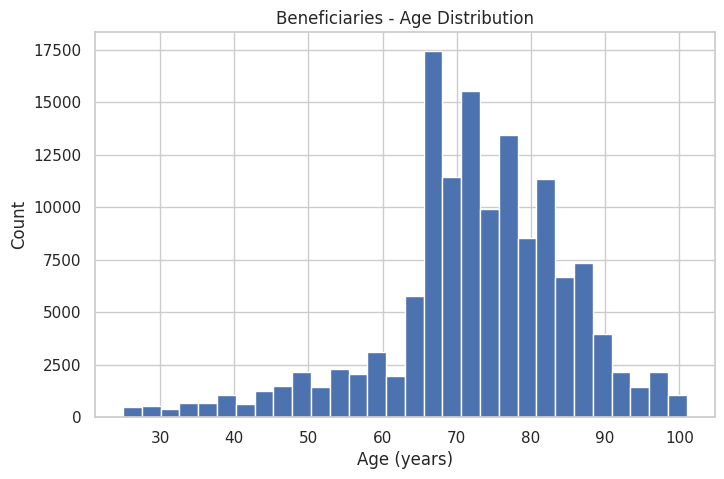

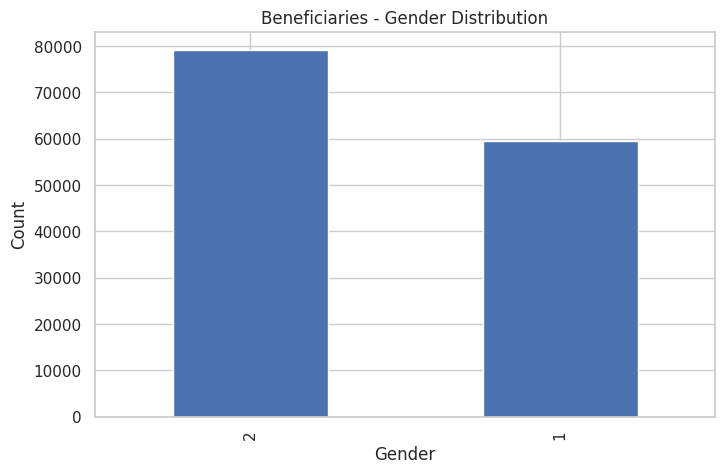


Chronic condition columns found: ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


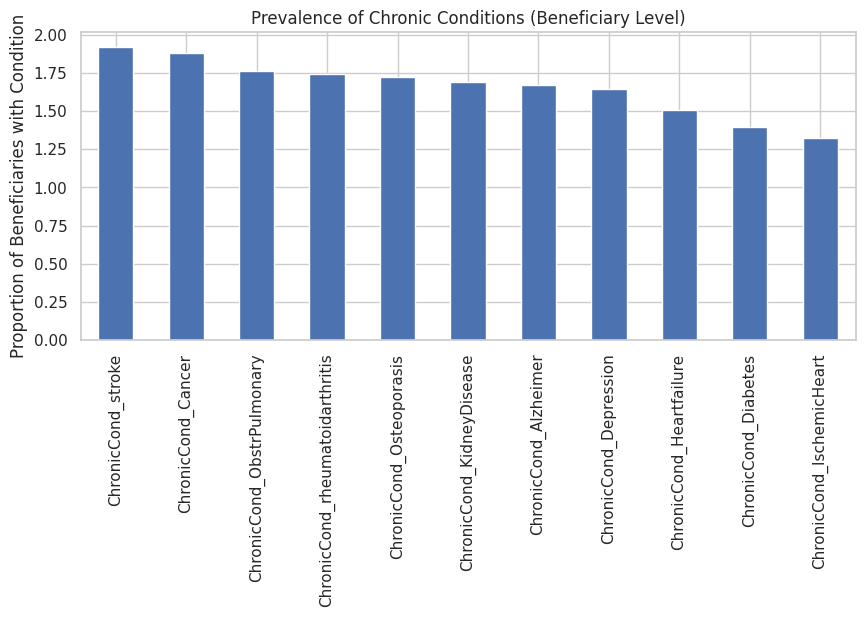

In [12]:
# === 1.5.1 - Conduct exploratory analysis on beneficiaries ===

# Use one row per beneficiary (to avoid duplicates from multiple claims)
bene_df = all_claims.drop_duplicates(subset=['BeneID'])

print("Beneficiary dataset (after deduplication) shape:", bene_df.shape)
print("\nBasic info:")
print(bene_df[['BeneID', 'Gender', 'Race']].info())

# 1) Age distribution
plt.figure()
bene_df['Age'].hist(bins=30)
plt.title('Beneficiaries - Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

# 2) Gender distribution
plt.figure()
bene_df['Gender'].value_counts().plot(kind='bar')
plt.title('Beneficiaries - Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# 3) Example chronic condition prevalence (if these columns exist)
chronic_cols = [col for col in bene_df.columns if col.startswith('ChronicCond_')]
print("\nChronic condition columns found:", chronic_cols)

if chronic_cols:
    chronic_mean = bene_df[chronic_cols].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    chronic_mean.plot(kind='bar')
    plt.title('Prevalence of Chronic Conditions (Beneficiary Level)')
    plt.ylabel('Proportion of Beneficiaries with Condition')
    plt.show()


Claims dataset shape: (558211, 54)


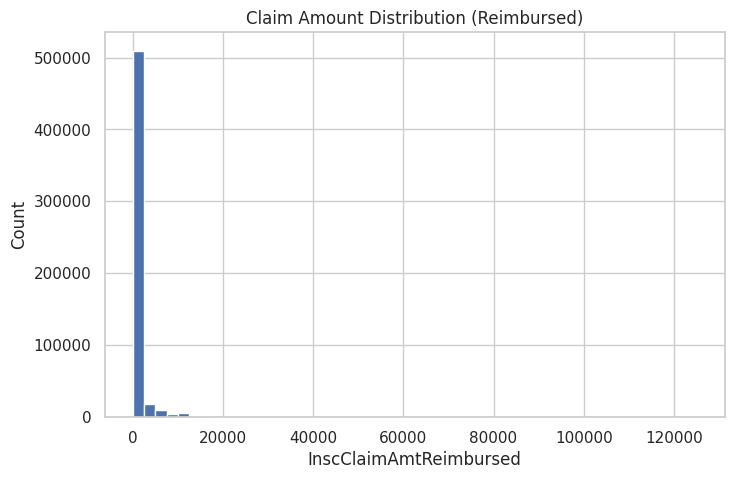

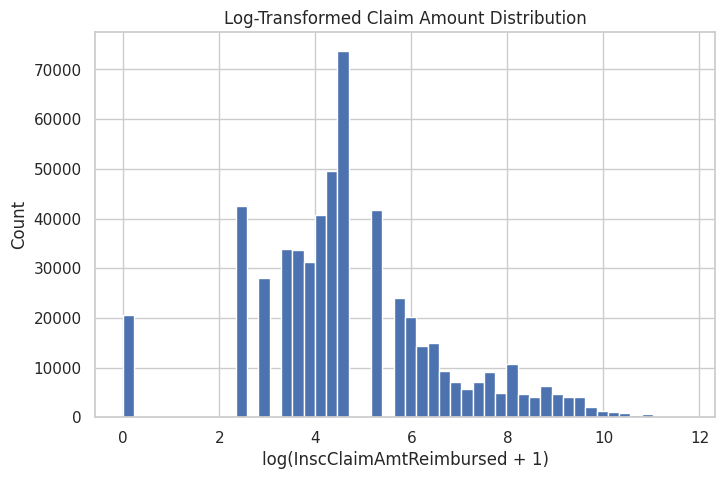

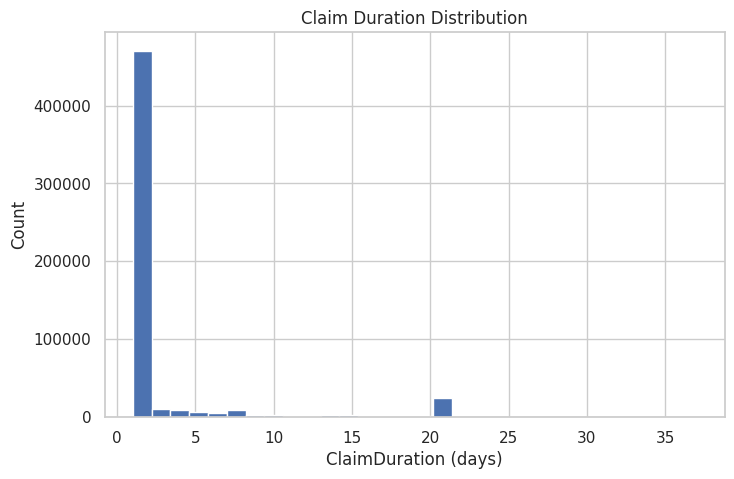

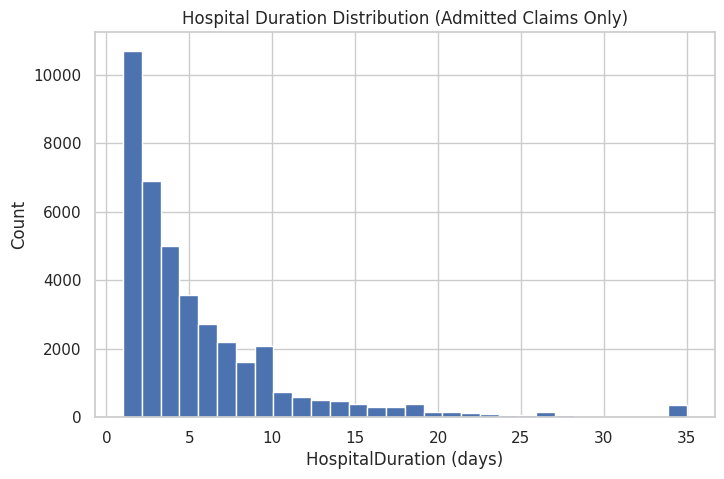

95th percentile of claim amount: 5000.0
99th percentile of claim amount: 17000.0


In [13]:
# === 1.5.1 - Conduct exploratory analysis on claims ===

print("Claims dataset shape:", all_claims.shape)

# 1) Distribution of reimbursed claim amounts
plt.figure()
all_claims['InscClaimAmtReimbursed'].hist(bins=50)
plt.title('Claim Amount Distribution (Reimbursed)')
plt.xlabel('InscClaimAmtReimbursed')
plt.ylabel('Count')
plt.show()

# Optional: Log-scale view for outliers
plt.figure()
(all_claims['InscClaimAmtReimbursed'] + 1).apply(np.log).hist(bins=50)
plt.title('Log-Transformed Claim Amount Distribution')
plt.xlabel('log(InscClaimAmtReimbursed + 1)')
plt.ylabel('Count')
plt.show()

# 2) Claim duration distribution
plt.figure()
all_claims['ClaimDuration'].hist(bins=30)
plt.title('Claim Duration Distribution')
plt.xlabel('ClaimDuration (days)')
plt.ylabel('Count')
plt.show()

# 3) Hospital duration (for admitted patients only)
if 'HospitalDuration' in all_claims.columns:
    plt.figure()
    all_claims.loc[all_claims['HospitalDuration'] > 0, 'HospitalDuration'].hist(bins=30)
    plt.title('Hospital Duration Distribution (Admitted Claims Only)')
    plt.xlabel('HospitalDuration (days)')
    plt.ylabel('Count')
    plt.show()

# 4) Outlier quick check for claim amount using quantiles
q95 = all_claims['InscClaimAmtReimbursed'].quantile(0.95)
q99 = all_claims['InscClaimAmtReimbursed'].quantile(0.99)
print(f"95th percentile of claim amount: {q95}")
print(f"99th percentile of claim amount: {q99}")


Claims per provider (summary):
count    5410.000000
mean      103.181331
std       272.456989
min         1.000000
25%        10.000000
50%        31.000000
75%        87.000000
max      8240.000000
Name: ClaimID, dtype: float64


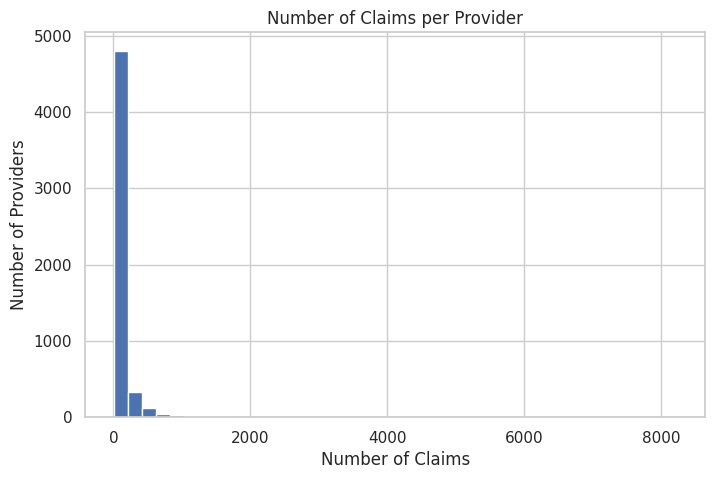


Total reimbursed amount per provider (summary):
count    5.410000e+03
mean     1.028730e+05
std      2.687367e+05
min      0.000000e+00
25%      4.460000e+03
50%      1.980500e+04
75%      8.556500e+04
max      5.996050e+06
Name: InscClaimAmtReimbursed, dtype: float64


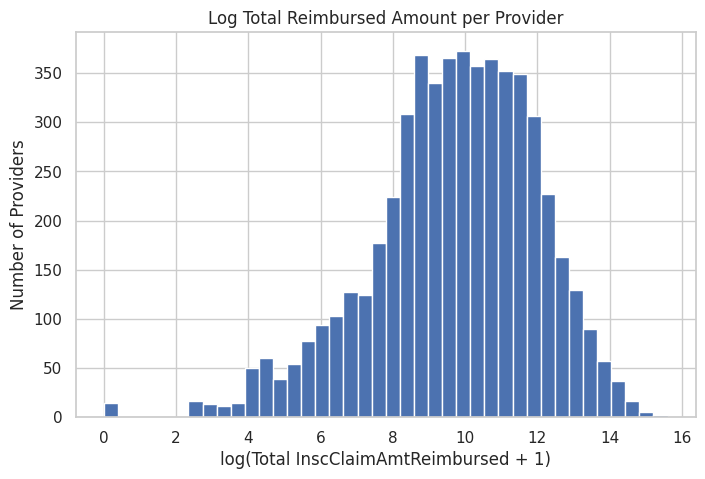

In [14]:
# === 1.5.1 - Conduct exploratory analysis on providers (quick view) ===

# Number of claims per provider
claims_per_provider = all_claims.groupby('Provider')['ClaimID'].nunique()
print("Claims per provider (summary):")
print(claims_per_provider.describe())

plt.figure()
claims_per_provider.hist(bins=40)
plt.title('Number of Claims per Provider')
plt.xlabel('Number of Claims')
plt.ylabel('Number of Providers')
plt.show()

# Total reimbursed amount per provider
reimb_per_provider = all_claims.groupby('Provider')['InscClaimAmtReimbursed'].sum()
print("\nTotal reimbursed amount per provider (summary):")
print(reimb_per_provider.describe())

plt.figure()
(reimb_per_provider + 1).apply(np.log).hist(bins=40)
plt.title('Log Total Reimbursed Amount per Provider')
plt.xlabel('log(Total InscClaimAmtReimbursed + 1)')
plt.ylabel('Number of Providers')
plt.show()


In [ ]:
# === Helper: basic provider-level summary for fraud comparison ===

provider_summary = all_claims.groupby('Provider').agg({
    'ClaimID': 'nunique',
    'BeneID': 'nunique',
    'InscClaimAmtReimbursed': ['sum', 'mean'],
    'ClaimDuration': 'mean',
    'Age': 'mean',
    'IsAdmitted': 'mean'
})

# Flatten column MultiIndex
provider_summary.columns = [
    'NumClaims',
    'NumUniqueBeneficiaries',
    'TotalReimbursed',
    'AvgClaimAmount',
    'AvgClaimDuration',
    'AvgAge',
    'AdmissionRate'
]

# Add fraud label (same per provider, so take first)
provider_labels = all_claims.groupby('Provider')['PotentialFraud'].first()
provider_summary = provider_summary.join(provider_labels)

provider_summary.head()


,NumClaims,NumUniqueBeneficiaries,TotalReimbursed,AvgClaimAmount,AvgClaimDuration,AvgAge,AdmissionRate,PotentialFraud
Provider,,,,,,,,
PRV51001,25,24,104640,4185.600000,2.440000,77.880000,0.200000,No
PRV51003,132,117,605670,4588.409091,4.674242,69.106061,0.469697,Yes
PRV51004,149,138,52170,350.134228,2.429530,71.302013,0.000000,No
PRV51005,1165,495,280910,241.124464,2.088412,69.567382,0.000000,Yes
PRV51007,72,58,33710,468.194444,1.958333,68.375000,0.041667,No


In [ ]:
# === 1.5.1 - Compare fraudulent and legitimate providers (descriptive stats) ===

fraud_prov = provider_summary[provider_summary['PotentialFraud'] == 'Yes']
legit_prov = provider_summary[provider_summary['PotentialFraud'] == 'No']

print("Number of fraudulent providers:", fraud_prov.shape[0])
print("Number of legitimate providers:", legit_prov.shape[0])

cols_to_compare = [
    'NumClaims',
    'NumUniqueBeneficiaries',
    'TotalReimbursed',
    'AvgClaimAmount',
    'AvgClaimDuration',
    'AvgAge',
    'AdmissionRate'
]

print("\n--- Legitimate Providers (No) ---")
print(legit_prov[cols_to_compare].describe())

print("\n--- Fraudulent Providers (Yes) ---")
print(fraud_prov[cols_to_compare].describe())


Number of fraudulent providers: 506
Number of legitimate providers: 4904

--- Legitimate Providers (No) ---
         NumClaims  NumUniqueBeneficiaries  TotalReimbursed  AvgClaimAmount  \
count  4904.000000             4904.000000     4.904000e+03     4904.000000   
mean     70.435359               49.110318     5.319372e+04     1523.780804   
std     128.942510               81.982703     1.023423e+05     3375.565858   
min       1.000000                1.000000     0.000000e+00        0.000000   
25%       9.000000                8.000000     3.797500e+03      220.498252   
50%      27.000000               22.000000     1.505500e+04      332.192088   
75%      72.000000               53.000000     5.742250e+04     1024.733852   
max    1245.000000              807.000000     1.311040e+06    57000.000000   

       AvgClaimDuration       AvgAge  AdmissionRate  
count       4904.000000  4904.000000    4904.000000  
mean           2.914981    72.800828       0.125518  
std            2.0

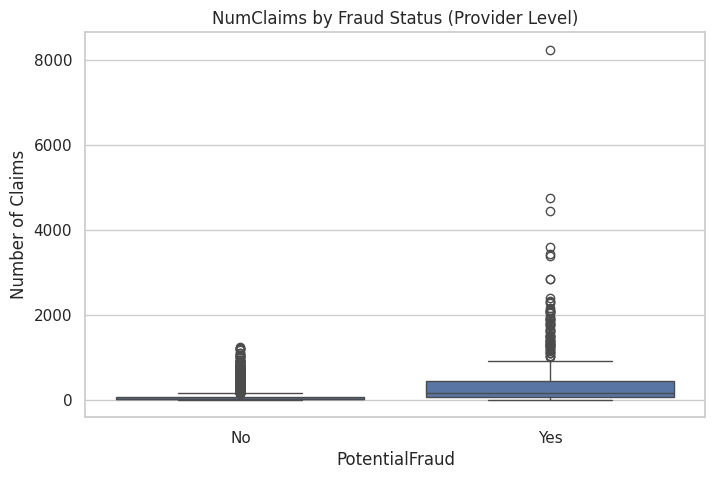

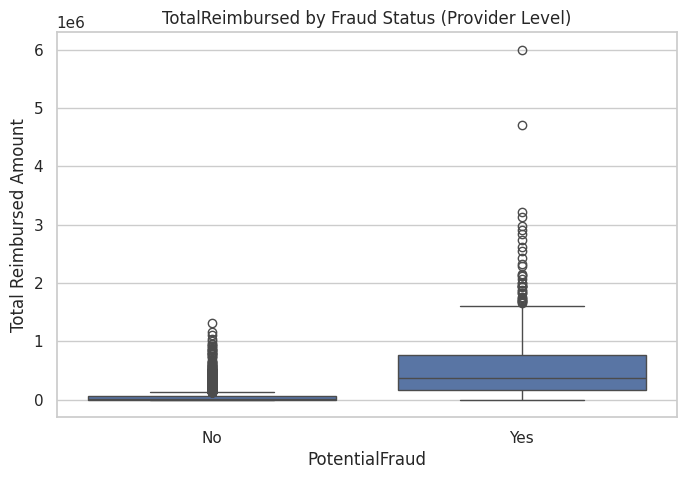

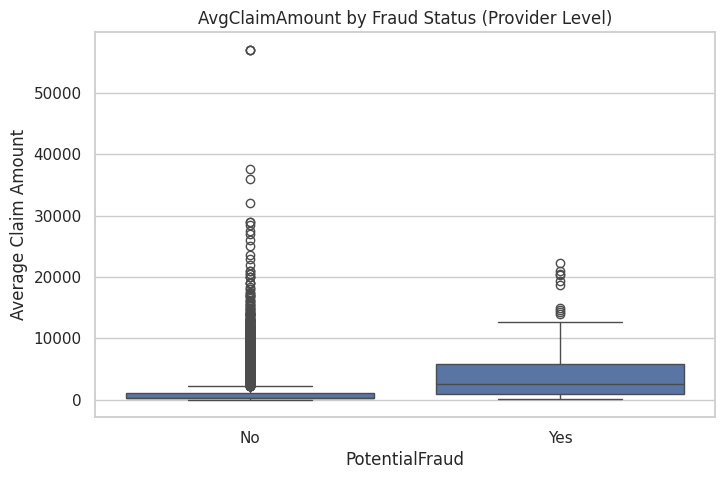

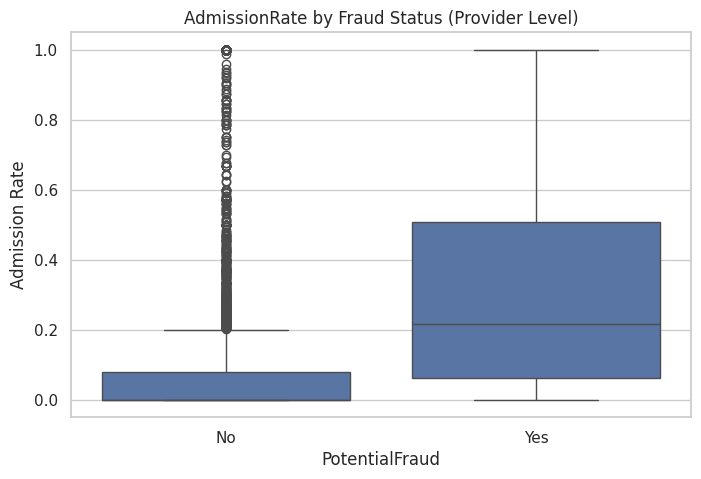

In [ ]:
# === Visual comparison: fraud vs non-fraud (provider-level) ===

def boxplot_feature(feature_name, ylabel=None):
    plt.figure()
    sns.boxplot(
        data=provider_summary,
        x='PotentialFraud',
        y=feature_name
    )
    plt.title(f'{feature_name} by Fraud Status (Provider Level)')
    plt.xlabel('PotentialFraud')
    plt.ylabel(ylabel if ylabel else feature_name)
    plt.show()

boxplot_feature('NumClaims', 'Number of Claims')
boxplot_feature('TotalReimbursed', 'Total Reimbursed Amount')
boxplot_feature('AvgClaimAmount', 'Average Claim Amount')
boxplot_feature('AdmissionRate', 'Admission Rate')


In [ ]:
# === 1.5.1 - Define aggregation strategy to provider-level ===

# Separate counts by ClaimType to keep inpatient vs outpatient info
pivot_claim_type = (
    all_claims
    .pivot_table(
        index='Provider',
        columns='ClaimType',
        values='ClaimID',
        aggfunc='nunique',
        fill_value=0
    )
)

# Ensure consistent column names (in case only one type exists)
for col in ['Inpatient', 'Outpatient']:
    if col not in pivot_claim_type.columns:
        pivot_claim_type[col] = 0

pivot_claim_type = pivot_claim_type.rename(
    columns={'Inpatient': 'NumInpatientClaims', 'Outpatient': 'NumOutpatientClaims'}
)

# Main aggregation
provider_agg = all_claims.groupby('Provider').agg({
    'ClaimID': 'nunique',                    # total number of claims
    'BeneID': 'nunique',                     # unique beneficiaries
    'InscClaimAmtReimbursed': ['sum', 'mean'],
    'ClaimDuration': ['mean'],
    'HospitalDuration': ['mean'],
    'Age': ['mean'],
    'IsAdmitted': ['mean'],
})

provider_agg.columns = [
    'NumClaims',
    'NumUniqueBeneficiaries',
    'TotalReimbursed',
    'AvgClaimAmount',
    'AvgClaimDuration',
    'AvgHospitalDuration',
    'AvgAge',
    'AdmissionRate'
]

# Merge with inpatient/outpatient split
provider_agg = provider_agg.join(pivot_claim_type)

# Add fraud label
provider_agg = provider_agg.join(provider_labels)

provider_agg.head()


,NumClaims,NumUniqueBeneficiaries,TotalReimbursed,AvgClaimAmount,AvgClaimDuration,AvgHospitalDuration,AvgAge,AdmissionRate,NumInpatientClaims,NumOutpatientClaims,PotentialFraud
Provider,,,,,,,,,,,
PRV51001,25,24,104640,4185.600000,2.440000,1.000000,77.880000,0.200000,5,20,No
PRV51003,132,117,605670,4588.409091,4.674242,2.424242,69.106061,0.469697,62,70,Yes
PRV51004,149,138,52170,350.134228,2.429530,0.000000,71.302013,0.000000,0,149,No
PRV51005,1165,495,280910,241.124464,2.088412,0.000000,69.567382,0.000000,0,1165,Yes
PRV51007,72,58,33710,468.194444,1.958333,0.222222,68.375000,0.041667,3,69,No


In [ ]:
# Save the provider-level dataset for modeling notebook
provider_agg.reset_index().to_csv('data/provider_level_dataset.csv', index=False)
print("Saved provider_level_dataset.csv with shape:", provider_agg.shape)


Saved provider_level_dataset.csv with shape: (5410, 11)


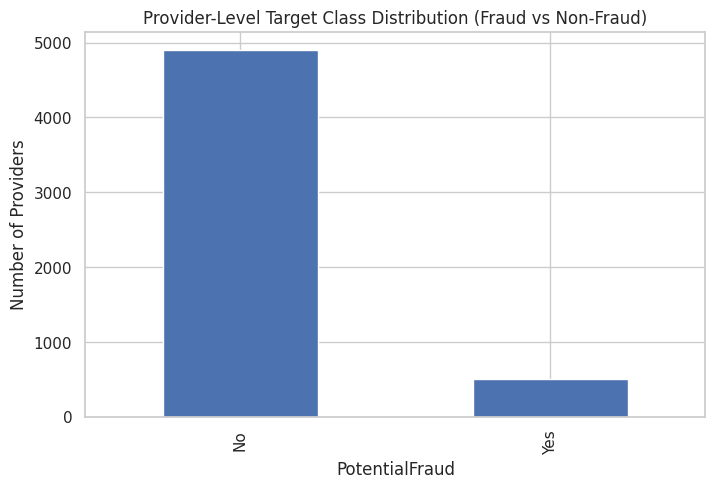

In [ ]:
# === 1.5.1 - Produce core plots: target class distribution ===

plt.figure()
provider_agg['PotentialFraud'].value_counts().plot(kind='bar')
plt.title('Provider-Level Target Class Distribution (Fraud vs Non-Fraud)')
plt.xlabel('PotentialFraud')
plt.ylabel('Number of Providers')
plt.show()


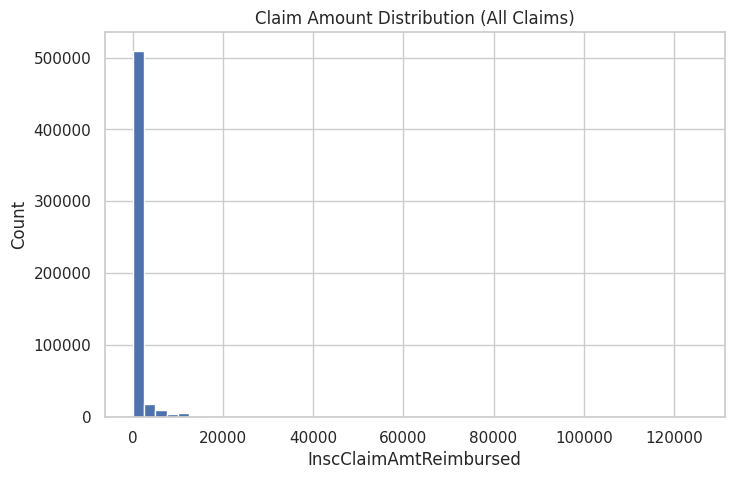

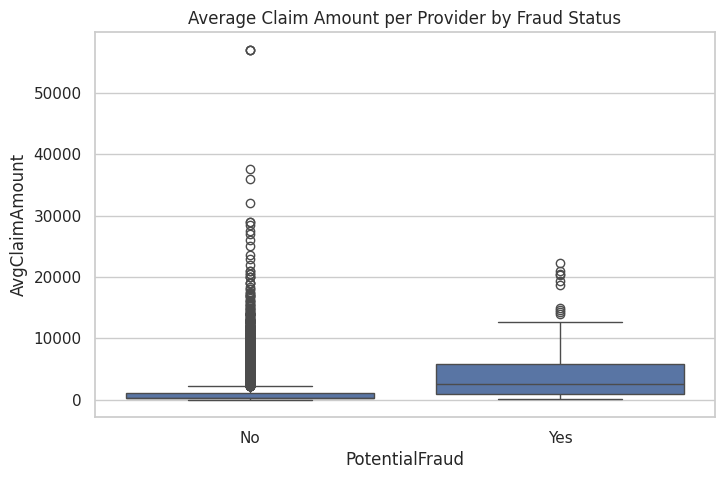

In [ ]:
# === 1.5.1 - Produce core plots: claim amount trends ===

# 1) Claim-level
plt.figure()
all_claims['InscClaimAmtReimbursed'].hist(bins=50)
plt.title('Claim Amount Distribution (All Claims)')
plt.xlabel('InscClaimAmtReimbursed')
plt.ylabel('Count')
plt.show()

# 2) Provider-level average claim amount by fraud status
plt.figure()
sns.boxplot(
    data=provider_agg,
    x='PotentialFraud',
    y='AvgClaimAmount'
)
plt.title('Average Claim Amount per Provider by Fraud Status')
plt.xlabel('PotentialFraud')
plt.ylabel('AvgClaimAmount')
plt.show()


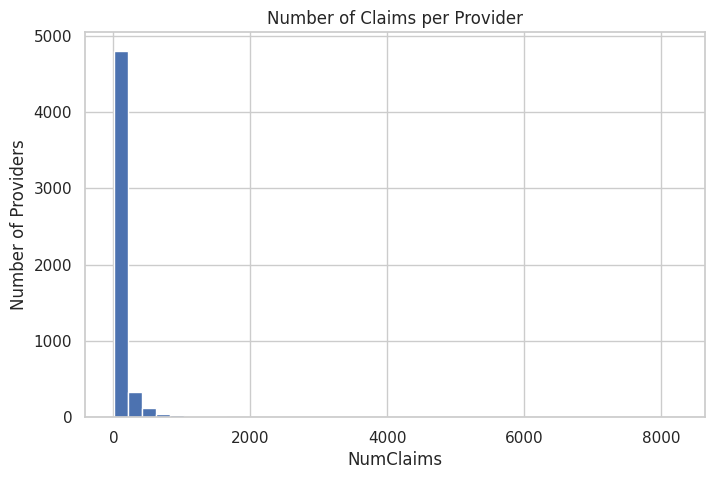

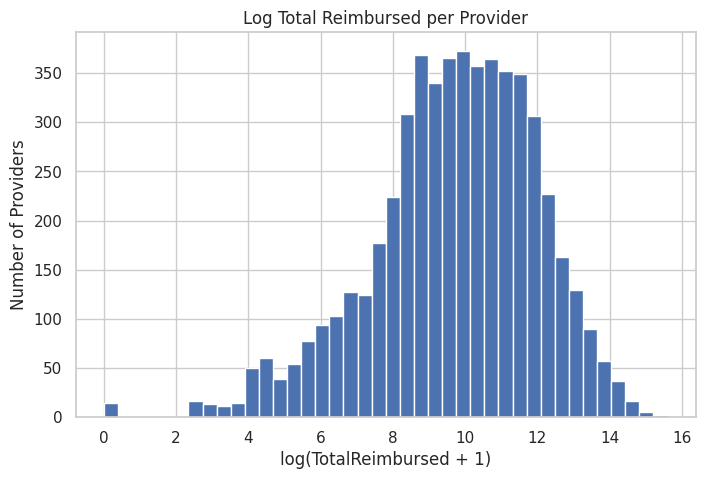

In [ ]:
# === 1.5.1 - Produce core plots: provider-level summaries ===

# Histogram of number of claims per provider
plt.figure()
provider_agg['NumClaims'].hist(bins=40)
plt.title('Number of Claims per Provider')
plt.xlabel('NumClaims')
plt.ylabel('Number of Providers')
plt.show()

# Histogram of total reimbursed per provider (log scale)
plt.figure()
(provider_agg['TotalReimbursed'] + 1).apply(np.log).hist(bins=40)
plt.title('Log Total Reimbursed per Provider')
plt.xlabel('log(TotalReimbursed + 1)')
plt.ylabel('Number of Providers')
plt.show()


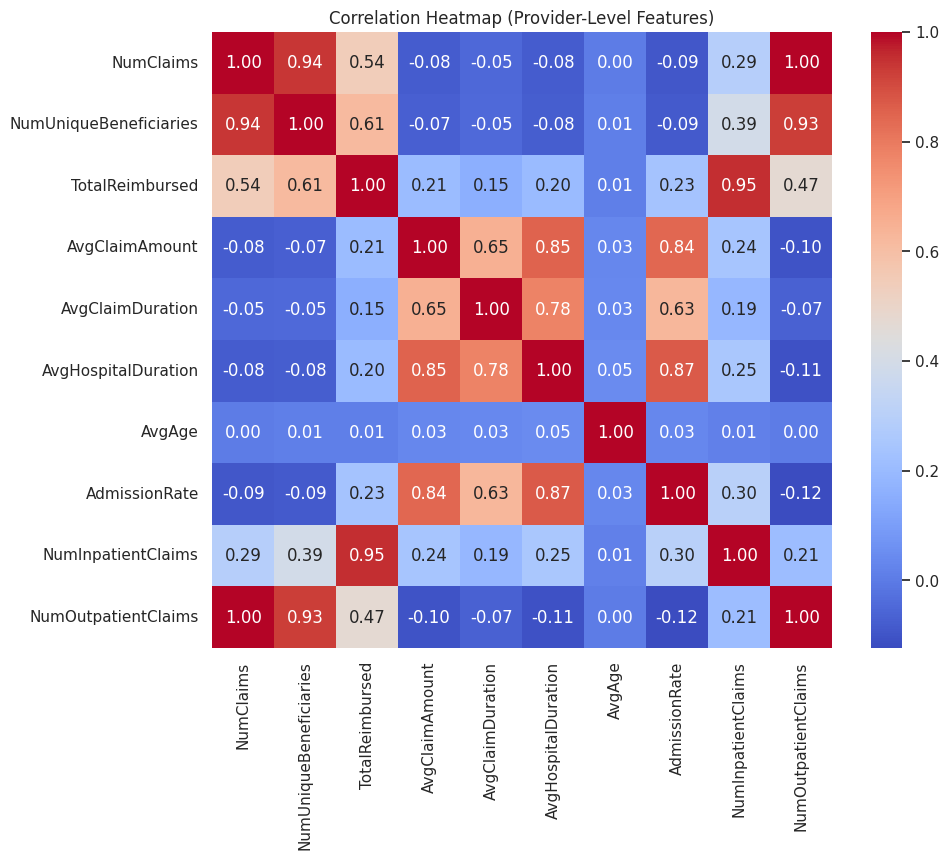

In [ ]:
# === 1.5.1 - Produce core plots: correlation heatmap ===

numeric_cols = [
    'NumClaims',
    'NumUniqueBeneficiaries',
    'TotalReimbursed',
    'AvgClaimAmount',
    'AvgClaimDuration',
    'AvgHospitalDuration',
    'AvgAge',
    'AdmissionRate',
    'NumInpatientClaims',
    'NumOutpatientClaims'
]

corr_matrix = provider_agg[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (Provider-Level Features)')
plt.show()


       NumProviders  NumFraudProviders  FraudRate
State                                            
49              107                 21   0.196262
30               16                  3   0.187500
22               78                 12   0.153846
31               79                 12   0.151899
44              114                 17   0.149123
33              229                 34   0.148472
1               101                 13   0.128713
39              170                 21   0.123529
36              187                 23   0.122995
29               25                  3   0.120000


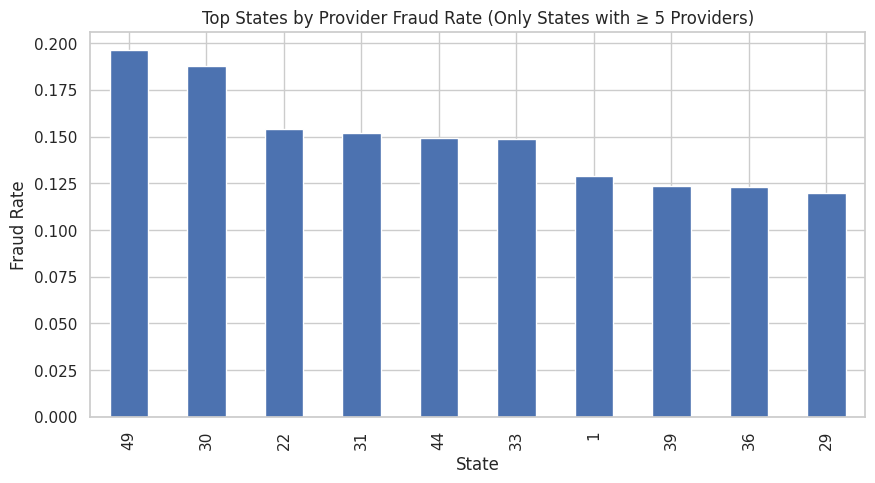

In [ ]:
# === 1.5.1 - Produce core plots: geographic patterns ===

# One row per provider-state (take the main state per provider = most frequent)
provider_state = (
    all_claims
    .groupby(['Provider', 'State'])['ClaimID']
    .count()
    .reset_index()
)

# For each provider, pick the state where they have the most claims
provider_state = provider_state.sort_values(['Provider', 'ClaimID'], ascending=[True, False])
provider_state_main = provider_state.drop_duplicates(subset='Provider')

# Attach fraud label to provider-state
provider_state_main = provider_state_main.merge(
    provider_labels.rename('PotentialFraud'),
    left_on='Provider',
    right_index=True,
    how='left'
)

# Compute fraud rate per state
state_stats = provider_state_main.groupby('State').agg(
    NumProviders=('Provider', 'nunique'),
    NumFraudProviders=('PotentialFraud', lambda x: (x == 'Yes').sum())
)

state_stats['FraudRate'] = state_stats['NumFraudProviders'] / state_stats['NumProviders']

state_stats = state_stats.sort_values('FraudRate', ascending=False)

print(state_stats.head(10))

# Plot top 10 states by fraud rate (minimum provider count filter)
top_states = state_stats[state_stats['NumProviders'] >= 5].head(10)

plt.figure(figsize=(10, 5))
top_states['FraudRate'].plot(kind='bar')
plt.title('Top States by Provider Fraud Rate (Only States with ≥ 5 Providers)')
plt.xlabel('State')
plt.ylabel('Fraud Rate')
plt.show()


In [ ]:
# --- REBUILD PROVIDER-LEVEL DATASET FROM all_claims ---

# 1) Fraud label per provider
provider_labels = all_claims.groupby('Provider')['PotentialFraud'].first()

# 2) Pivot claim type to get Inpatient vs Outpatient counts
pivot_claim_type = (
    all_claims
    .pivot_table(
        index='Provider',
        columns='ClaimType',
        values='ClaimID',
        aggfunc='nunique',
        fill_value=0
    )
)

# Make sure both columns exist
for col in ['Inpatient', 'Outpatient']:
    if col not in pivot_claim_type.columns:
        pivot_claim_type[col] = 0

pivot_claim_type = pivot_claim_type.rename(
    columns={'Inpatient': 'NumInpatientClaims', 'Outpatient': 'NumOutpatientClaims'}
)

# 3) Main aggregation for numeric features
provider_agg = all_claims.groupby('Provider').agg({
    'ClaimID': 'nunique',
    'BeneID': 'nunique',
    'InscClaimAmtReimbursed': ['sum', 'mean'],
    'ClaimDuration': ['mean'],
    'HospitalDuration': ['mean'],
    'Age': ['mean'],
    'IsAdmitted': ['mean'],
})

# Flatten column names
provider_agg.columns = [
    'NumClaims',
    'NumUniqueBeneficiaries',
    'TotalReimbursed',
    'AvgClaimAmount',
    'AvgClaimDuration',
    'AvgHospitalDuration',
    'AvgAge',
    'AdmissionRate'
]

# 4) Merge all pieces together
provider_agg = provider_agg.join(pivot_claim_type)
provider_agg = provider_agg.join(provider_labels)

print("Provider-level dataset shape:", provider_agg.shape)
provider_agg.head()


Provider-level dataset shape: (5410, 11)


,NumClaims,NumUniqueBeneficiaries,TotalReimbursed,AvgClaimAmount,AvgClaimDuration,AvgHospitalDuration,AvgAge,AdmissionRate,NumInpatientClaims,NumOutpatientClaims,PotentialFraud
Provider,,,,,,,,,,,
PRV51001,25,24,104640,4185.600000,2.440000,1.000000,77.880000,0.200000,5,20,No
PRV51003,132,117,605670,4588.409091,4.674242,2.424242,69.106061,0.469697,62,70,Yes
PRV51004,149,138,52170,350.134228,2.429530,0.000000,71.302013,0.000000,0,149,No
PRV51005,1165,495,280910,241.124464,2.088412,0.000000,69.567382,0.000000,0,1165,Yes
PRV51007,72,58,33710,468.194444,1.958333,0.222222,68.375000,0.041667,3,69,No


In [ ]:
# --- ADD CHRONIC CONDITION PREVALENCE PER PROVIDER ---

# Find all chronic condition columns (they usually start with 'ChronicCond_')
chronic_cols = [c for c in all_claims.columns if c.startswith('ChronicCond_')]
print("Chronic condition columns found:", chronic_cols)

if chronic_cols:
    # For each provider, compute the mean of each chronic condition indicator.
    # Since these columns are 0/1, the mean = proportion of claims with that condition.
    chronic_by_provider = all_claims.groupby('Provider')[chronic_cols].mean()

    # Join the chronic condition features onto provider_agg
    provider_agg = provider_agg.join(chronic_by_provider)

    print("Added chronic condition prevalence features at provider level.")
    print("New provider_agg shape:", provider_agg.shape)
else:
    print("No chronic condition columns found. Skipping chronic prevalence features.")


Chronic condition columns found: ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']
Added chronic condition prevalence features at provider level.
New provider_agg shape: (5410, 22)


In [ ]:
# --- ADD INPATIENT / OUTPATIENT SHARE FEATURES ---

# To avoid division by zero, handle providers with NumClaims == 0 (shouldn't really happen, but just in case)
provider_agg['NumClaims_safe'] = provider_agg['NumClaims'].replace(0, np.nan)

provider_agg['InpatientShare'] = provider_agg['NumInpatientClaims'] / provider_agg['NumClaims_safe']
provider_agg['OutpatientShare'] = provider_agg['NumOutpatientClaims'] / provider_agg['NumClaims_safe']

# Fill any NaNs back with 0 (for safety)
provider_agg['InpatientShare'] = provider_agg['InpatientShare'].fillna(0)
provider_agg['OutpatientShare'] = provider_agg['OutpatientShare'].fillna(0)

# We don't need the helper column anymore
provider_agg = provider_agg.drop(columns=['NumClaims_safe'])

print("Added InpatientShare and OutpatientShare features.")
print("Final provider_agg shape before saving:", provider_agg.shape)
provider_agg.head()


Added InpatientShare and OutpatientShare features.
Final provider_agg shape before saving: (5410, 24)


,NumClaims,NumUniqueBeneficiaries,TotalReimbursed,AvgClaimAmount,AvgClaimDuration,AvgHospitalDuration,AvgAge,AdmissionRate,NumInpatientClaims,NumOutpatientClaims,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,InpatientShare,OutpatientShare
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51001,25,24,104640,4185.600000,2.440000,1.000000,77.880000,0.200000,5,20,...,1.800000,1.600000,1.640000,1.160000,1.080000,1.760000,1.680000,1.760000,0.200000,0.800000
PRV51003,132,117,605670,4588.409091,4.674242,2.424242,69.106061,0.469697,62,70,...,1.924242,1.689394,1.590909,1.242424,1.151515,1.750000,1.712121,1.909091,0.469697,0.530303
PRV51004,149,138,52170,350.134228,2.429530,0.000000,71.302013,0.000000,0,149,...,1.892617,1.724832,1.577181,1.295302,1.275168,1.671141,1.691275,1.885906,0.000000,1.000000
PRV51005,1165,495,280910,241.124464,2.088412,0.000000,69.567382,0.000000,0,1165,...,1.858369,1.746781,1.583691,1.314163,1.231760,1.704721,1.715880,1.893562,0.000000,1.000000
PRV51007,72,58,33710,468.194444,1.958333,0.222222,68.375000,0.041667,3,69,...,1.833333,1.777778,1.597222,1.319444,1.291667,1.708333,1.694444,1.833333,0.041667,0.958333


In [ ]:
provider_agg.reset_index().to_csv("data/provider_level_dataset.csv", index=False)
print("Saved provider_level_dataset.csv inside /data folder.")


Saved provider_level_dataset.csv inside /data folder.


In [ ]:
import os
print(os.getcwd())


/content/drive/.shortcut-targets-by-id/1S9cUDGWSTIdS3jzuHETJGQtUeBEujiL0/fraud_detection_project
